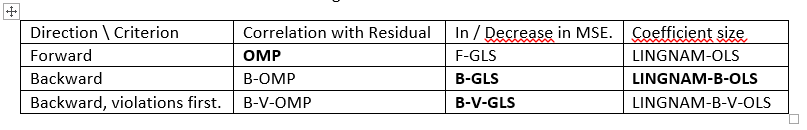

In [3]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

import scipy.linalg as slin

from importlib import reload  # Python 3.4+

A:
[[-0.64  0.  ]
 [ 0.68  0.  ]]

P:
[[1. 0.]
 [0. 1.]].


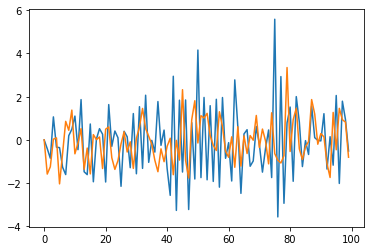

In [90]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 2, 2

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.4, high = 0.7, tril = False)

## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

In [91]:
def OLS(X):
    """Performs OLS on the data X"""
    
    # initialize OLS matrix
    W_OLS = np.zeros((n, n))
    
    # get per column
    for i in range(n):
        # closed form solution per OLS
        W_OLS[:, i] = np.linalg.inv(X[:-1].T @ X[:-1]) @ X[:-1].T @ X[1:, i]
        
    # return OLS solution
    return W_OLS

print(f"Dense OLS solution:\n{np.round(OLS(X), 2)}.")

Dense OLS solution:
[[-0.61  0.02]
 [ 0.67  0.04]].


In [154]:
def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2 * W2)  # (Zheng et al. 2018)
    h = np.trace(E) - n

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(n):
        for j in range(n):
            # remove Wij
            tmp = W[i][j]
            W[i][j] = 0
            
            # check h
            h_diff = h_val - _h(W)
            
            # check change
            if h_diff > epsilon:
                violators.add((i, j))
            
            # add Wij back
            W[i][j] = tmp

    return violators

In [94]:
def backwards_selection_step(W, X, use_violators = True):
    """Performs one backwards step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # get all violating edges
    violators = get_all_violating_edges(W)
    
    if not use_violators:
        violators = list(zip(np.nonzero(W)[0], np.nonzero(W)[1]))
    
    # if there are no violators, we are already done
    if len(violators) == 0: return W
    
    # variables to keep track of best
    best_col_to_change = None
    best_row_to_change = None
    new_column = None
    score = np.inf

    # iterate over all violators
    for row, col in violators:
        # copy W_hat before modifying 
        W_copy = W.copy()
        
        # set index of violator to zero
        W_copy[row][col] = 0
    
        # get all non_zero indices after removing violator
        indices = W_copy[:, col].nonzero()[0]
        
        # perform least squares without this violator
        W_copy[indices, col] = np.linalg.inv(X[:-1, indices].T @ X[:-1, indices]) @ X[:-1, indices].T @ X[1:, col]
    
        # if we have improved, check if best choice so far
        if h.MSE(W_copy, X) < score:
            best_col_to_change = col
            best_row_to_change = row
            new_column = W_copy[:, col]
            score = h.MSE(W_copy, X)
    
    # we greedily pick the best choice we have
    W[:, best_col_to_change] = new_column
    
    # return W_hat with one coefficient less
    return W, [best_row_to_change, best_col_to_change], score

OLS_after_one_step, edge_to_remove, score = backwards_selection_step(OLS(X), X)
print(f"OLS solution after removing the least important violator:\n{np.round(OLS_after_one_step, 2)}.")

OLS solution after removing the least important violator:
[[-0.61  0.  ]
 [ 0.67  0.04]].


In [95]:
def forward_selection_step(W, X, forbidden = []):
    """Performs one forward step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # variables to keep track of best
    best_col_to_change = None
    best_row_to_change = None
    new_column = None
    score = np.inf
    
    W_best = W.copy()
    
    W_check = W.copy()
    
    for row, col in forbidden:
        W_check[row][col] = -1
        
    # check which yields the best gain
    rows, cols = np.where(W_check == 0)
    
    if len(rows) == 0:
        print("Already Dense Matrix, no forward step possible")
        return W, None, None
        
    for row, col in zip(rows, cols):
        W_test = W.copy()
        indices = np.append(W[:, col].nonzero()[0], row)
        W_test[indices, col] = (np.linalg.inv(X[:-1, np.append(W[:, col].nonzero()[0], row)].T @ X[:-1, np.append(W[:, col].nonzero()[0], row)]) @ X[:-1, np.append(W[:, col].nonzero()[0], row)].T @ X[1:, col])

        if h.MSE(W_test, X) < score:
            score = h.MSE(W_test, X)
            W_best = W_test

            best_row_to_change = row
            best_col_to_change = col
    
    # return W_hat with one coefficient less
    return W_best, [best_row_to_change, best_col_to_change], score

OLS_after_one_step, edge_to_remove, score = forward_selection_step(np.zeros((n, n)), X)
print(f"OLS solution after removing the least important violator:\n{np.round(OLS_after_one_step, 2)}.")

OLS solution after removing the least important violator:
[[-0.64  0.  ]
 [ 0.    0.  ]].


## F-GLS

In [216]:
def F_GLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = np.zeros((n, n))
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = [h.MSE(W, X)]
    
    # Forbidden set
    F = []
    
    # while we still do not have a DAG
    while len(W.nonzero()[0]) < n * (n + 1) / 2:
        # greedily remove the edge that yields the smallest added error
        W_candidate, edge, score = forward_selection_step(W, X, forbidden = F)        
        
        if not h.is_dag(W_candidate):
            # add edge to forbidden set
            F.append(edge)
        else:
            W = W_candidate.copy()
            order_of_importance.append(edge)
            scores.append(score)
    
    W_return = W.copy()
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_greedy_backwards_OLS_v3, edge_order, scores = F_GLS(X)
print(f"OLS solution after iteratively adding the least most important edge until we have a dense DAG:\n{np.round(W_greedy_backwards_OLS_v3, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order}.")

OLS solution after iteratively adding the least most important edge until we have a dense DAG:
[[-0.66  0.    0.  ]
 [-0.45 -0.44  0.  ]
 [ 0.42  0.42  0.49]].
Importance of the added edges, from most to least important:
[[0, 0], [2, 2], [1, 0], [2, 0], [1, 1], [2, 1]].


## B-GLS

In [97]:
def B_GLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step(W, X, use_violators = False)
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step(W, X, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_greedy_backwards_OLS_v3, edge_order, scores = B_GLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_greedy_backwards_OLS_v3, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.61  0.  ]
 [ 0.67  0.04]].
Importance of the removed edges, from least to most important:
[[0, 1], [1, 1], [1, 0], [0, 0]].


### B-V-GLS

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.61  0.  ]
 [ 0.67  0.04]].
Importance of the removed edges, from least to most important:
[[0, 1], [1, 1], [1, 0], [0, 0]].


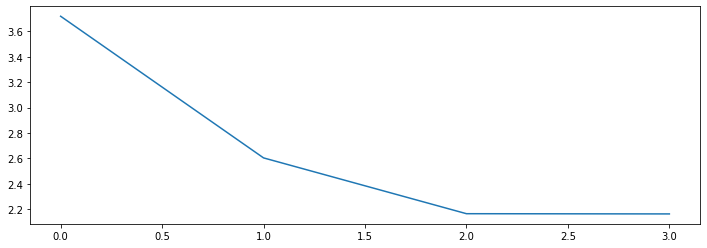

In [98]:
def B_V_GLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step(W, X, use_violators = True)
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_selection_step(W, X, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_B_V_GLS, edge_order, scores = B_V_GLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

### LINGNAM-F-OLS

In [99]:
def forward_selection_step_LINGNAM(W, X, forbidden = []):
    """Performs one forward step in selection.
       We remove the least important edge that violates DAG-ness.
       Least important means that removing it yields the smallest MSE increase.
    """
    
    # variables to keep track of best
    best_col_to_change = None
    best_row_to_change = None
    new_column = None
    coef_best = -1
    
    W_best = W.copy()
    
    W_check = W.copy()
    
    for row, col in forbidden:
        W_check[row][col] = -1
        
    # check which yields the best gain
    rows, cols = np.where(W_check == 0)
    
    if len(rows) == 0:
        print("Already Dense Matrix, no forward step possible")
        return W, None, None
        
    for row, col in zip(rows, cols):
        W_test = W.copy()
        indices = np.append(W[:, col].nonzero()[0], row)
        W_test[indices, col] = (np.linalg.inv(X[:-1, np.append(W[:, col].nonzero()[0], row)].T @ X[:-1, np.append(W[:, col].nonzero()[0], row)]) @ X[:-1, np.append(W[:, col].nonzero()[0], row)].T @ X[1:, col])
        
        if np.abs(W_test[row][col]) > coef_best:
            coef_best = np.abs(W_test[row][col])
            W_best = W_test.copy()

            best_row_to_change = row
            best_col_to_change = col
    
    # return W_hat with one coefficient less
    return W_best, [best_row_to_change, best_col_to_change], h.MSE(W_best, X)

OLS_after_one_step, edge_to_remove, score = forward_selection_step_LINGNAM(np.zeros((n, n)), X)
print(f"OLS solution after removing the least important violator:\n{np.round(OLS_after_one_step, 2)}.")

OLS solution after removing the least important violator:
[[0.   0.  ]
 [0.74 0.  ]].


OLS solution after iteratively adding the least most important edge until we have a dense DAG:
[[-0.66  0.    0.  ]
 [-0.45 -0.44  0.  ]
 [ 0.42  0.42  0.49]].
Importance of the added edges, from most to least important:
[[0, 0], [2, 2], [1, 0], [2, 0], [1, 1], [2, 1]].


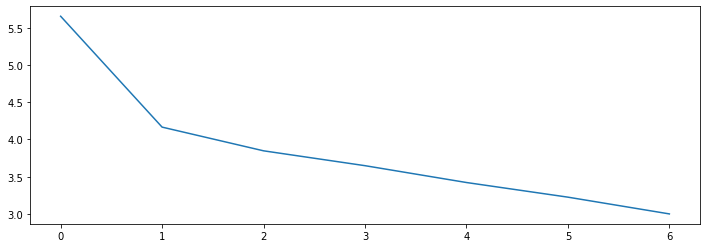

In [215]:
def F_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = np.zeros((n, n))
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = [h.MSE(W, X)]
    
    # Forbidden set
    F = []
    
    # while we still do not have a DAG
    while len(W.nonzero()[0]) < n * (n + 1) / 2:
        # greedily remove the edge that yields the smallest added error
        W_candidate, edge, score = forward_selection_step_LINGNAM(W, X, forbidden = F)        
        
        if not h.is_dag(W_candidate):
            # add edge to forbidden set
            F.append(edge)
            
        else:
            W = W_candidate.copy()
            order_of_importance.append(edge)
            scores.append(score)
    
    W_return = W.copy()
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_F_LINGNAM_OLS, edge_order, scores = F_LINGNAM_OLS(X)
print(f"OLS solution after iteratively adding the least most important edge until we have a dense DAG:\n{np.round(W_F_LINGNAM_OLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(scores)

### LINGNAM-B-OLS

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.59  0.    0.    0.  ]
 [-0.45 -0.48  0.    0.  ]
 [-0.59  0.63 -0.54  0.  ]
 [ 0.39  0.79 -0.6  -0.51]].
Importance of the removed edges, from least to most important:
[[0, 1], [1, 3], [0, 2], [1, 2], [2, 3], [0, 3], [3, 0], [1, 0], [2, 0], [1, 1], [3, 3], [2, 2], [0, 0], [3, 1], [3, 2], [2, 1]].


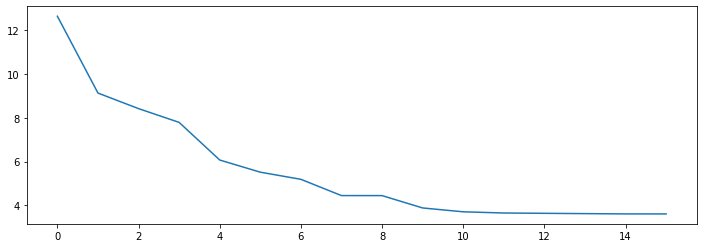

In [302]:
def B_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # Now that we have a DAG, we will greedily remove the least important edge
    # while we still do not have a DAG
    while not h.is_dag(W):
        
        # set zero values to impossible value
        W[W == 0] = 1e10
        
        # get smallest VIOLATING nonzero coefficient in absolute value
        row, col = np.argmin(np.abs(W)) // n, np.argmin(np.abs(W)) % n
        
        # set this to zero
        W[row][col] = 0
        
        # revert the zero values back to zero
        W[W == 1e10] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])

        edge = [row, col]
        
        score = h.MSE(W, X)
        
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:   
        
        # set zero values to impossible value
        W[W == 0] = 1e10
        
        # get smallest nonzero coefficient in absolute value
        row, col = np.argmin(np.abs(W)) // n, np.argmin(np.abs(W)) % n
        
        # set this to zero
        W[row][col] = 0
        
        # revert the zero values back to zero
        W[W == 1e10] = 0

        edge = [row, col]
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        score = h.MSE(W, X)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(h.MSE(W, X))

    # return the DAG W
    return W_return, order_of_importance, scores

W_B_LINGNAM_OLS, edge_order, scores = B_LINGNAM_OLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

### B-V-LINGNAM

OLS solution after iteratively removing the least important violators until we have a DAG:
[[-0.59  0.    0.    0.  ]
 [-0.45 -0.48  0.    0.  ]
 [-0.59  0.63 -0.54  0.  ]
 [ 0.39  0.79 -0.6  -0.51]].
Importance of the removed edges, from least to most important:
[[0, 1], [1, 3], [0, 2], [1, 2], [2, 3], [0, 3], [3, 0], [1, 0], [2, 0], [1, 1], [3, 3], [2, 2], [0, 0], [3, 1], [3, 2], [2, 1]].


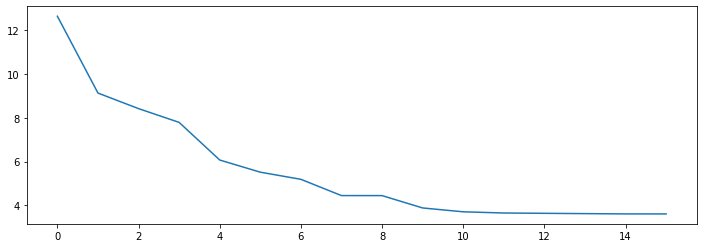

In [300]:
def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        # add edge and score to list
        order_of_importance.append([row, col])
        scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:   
        
        # set zero values to impossible value
        W[W == 0] = 1e10
        
        # get smallest nonzero coefficient in absolute value
        row, col = np.argmin(np.abs(W)) // n, np.argmin(np.abs(W)) % n
        
        # set this to zero
        W[row][col] = 0
        
        # revert the zero values back to zero
        W[W == 1e10] = 0

        edge = [row, col]
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        score = h.MSE(W, X)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_B_V_LINGNAM_OLS, edge_order, scores = B_V_LINGNAM_OLS(X)
print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

### B-OMP

In [224]:
def backwards_step_OMP(W, X, use_violators = True):
    
    def normalize(x): return x / np.linalg.norm(x)
    
    # get all violating edges
    violators = get_all_violating_edges(W)
    
    if not use_violators:
        violators = list(zip(np.nonzero(W)[0], np.nonzero(W)[1]))
    
    # if there are no violators, we are already done
    if len(violators) == 0: return W
    
    # variables to keep track of best
    best_col_to_change = None
    best_row_to_change = None
    new_column = None
    score = np.inf

    # iterate over all violators
    for row, col in violators:
        # copy W_hat before modifying 
        W_copy = W.copy()
        
        # set index of violator to zero
        W_copy[row][col] = 0
    
        # get all non_zero indices after removing violator
        indices = W_copy[:, col].nonzero()[0]
        
        # compute correlation with residual without this violator
        W_copy[indices, col] = np.linalg.inv(X[:-1, indices].T @ X[:-1, indices]) @ X[:-1, indices].T @ X[1:, col]
        
        # compute residual
        residual = (X[1:] - X[:-1] @ W_copy)[:, col]
        
        # if we have improved, check if best choice so far
        if np.abs(np.dot(normalize(X[:-1, row]), residual)) < score:
            best_col_to_change = col
            best_row_to_change = row
            new_column = W_copy[:, col]
            score = np.abs(np.dot(normalize(X[:-1, row]), residual))
    
    # we greedily pick the best choice we have
    W[:, best_col_to_change] = new_column
    
    # return W_hat with one coefficient less
    return W, [best_row_to_change, best_col_to_change], h.MSE(W, X)

B_OMP_after_one_step, edge_to_remove, score = backwards_step_OMP(OLS(X), X, use_violators = False)
print(f"OMP solution after removing the least important edge:\n{np.round(B_OMP_after_one_step, 2)}.")

OMP solution after removing the least important edge:
[[ 0.06 -0.05  0.13 -0.11  0.06]
 [-0.45  0.38 -0.15  0.1  -0.02]
 [ 0.49  0.47  0.56  0.01 -0.04]
 [ 0.46 -0.52  0.42  0.55 -0.08]
 [-0.16 -0.1  -0.38  0.   -0.05]].


OMP solution after iteratively removing the least important edge until we have a DAG:
[[ 0.    0.    0.    0.    0.  ]
 [-0.46  0.39  0.    0.    0.  ]
 [ 0.52  0.45  0.6   0.    0.  ]
 [ 0.47 -0.52  0.47  0.51  0.  ]
 [ 0.    0.   -0.36  0.    0.  ]].
Importance of the removed edges, from least to most important:
[[4, 3], [2, 3], [1, 4], [4, 4], [2, 4], [0, 1], [0, 0], [0, 4], [3, 4], [4, 1], [4, 0], [1, 3], [0, 2], [0, 3], [1, 2], [4, 2], [3, 0], [3, 2], [3, 1], [3, 3], [2, 1], [1, 1], [1, 0], [2, 0], [2, 2]].


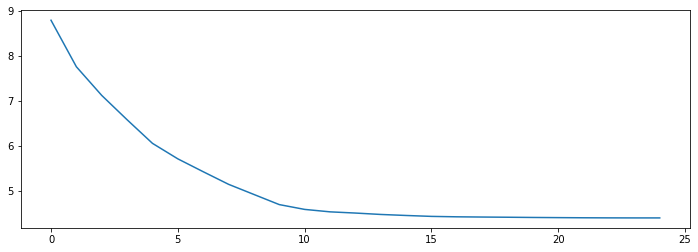

In [225]:
def B_OMP(X_total, tol = 0.0):
    # Data to work with
    X, Y = X_total[:-1], X_total[1:]
    
    # get full OLS solution of W
    W = OLS(X)
    
    ## Condensed information
    Psi = np.dot(X, X.T)
    K = np.dot(X, Y.T)
    Theta = [y.T.dot(y) for y in Y.T]
    
    # dimensions
    T, p = np.shape(X_total)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_step_OMP(W, X_total, use_violators = False)
        order_of_importance.append(edge)
        scores.append(score)
    
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:        
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_step_OMP(W, X_total, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_B_OMP, edge_order, scores = B_OMP(X)
print(f"OMP solution after iteratively removing the least important edge until we have a DAG:\n{np.round(W_B_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

OMP solution after iteratively removing the least important violator until we have a DAG:
[[ 0.05  0.    0.    0.    0.  ]
 [-0.45  0.39  0.    0.    0.  ]
 [ 0.5   0.45  0.6   0.    0.  ]
 [ 0.46 -0.52  0.47  0.51  0.  ]
 [-0.18 -0.11 -0.36  0.   -0.04]].
Importance of the removed edges, from least to most important:
[[4, 3], [2, 3], [1, 4], [2, 4], [0, 1], [0, 4], [3, 4], [1, 3], [0, 2], [0, 3], [1, 2], [4, 4], [0, 0], [4, 1], [4, 0], [4, 2], [3, 0], [3, 2], [3, 1], [3, 3], [2, 1], [1, 1], [1, 0], [2, 0], [2, 2]].


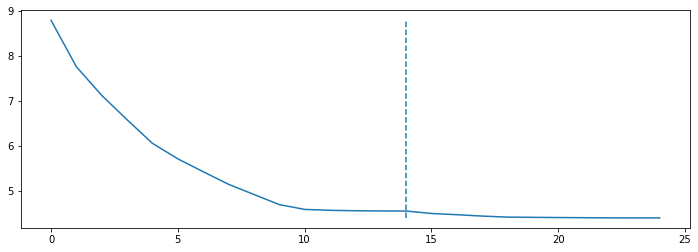

In [226]:
def B_V_OMP(X_total, tol = 0.0):
    # Data to work with
    X, Y = X_total[:-1], X_total[1:]
    
    # get full OLS solution of W
    W = OLS(X)
    
    ## Condensed information
    Psi = np.dot(X, X.T)
    K = np.dot(X, Y.T)
    Theta = [y.T.dot(y) for y in Y.T]
    
    # dimensions
    T, p = np.shape(X_total)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_step_OMP(W, X_total, use_violators = True)
        order_of_importance.append(edge)
        scores.append(score)
        
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
    while len(np.nonzero(W)[0]) > 0:        
        # greedily remove the edge that yields the smallest added error
        W, edge, score = backwards_step_OMP(W, X_total, use_violators = False)
        
        if score < tol: 
            break
            
        order_of_importance.append(edge)
        scores.append(score)
        
    # return the DAG W
    return W_return, order_of_importance, scores

W_B_V_OMP, edge_order, scores = B_V_OMP(X)
print(f"OMP solution after iteratively removing the least important violator until we have a DAG:\n{np.round(W_B_V_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.vlines(len(np.nonzero(W_B_V_OMP)[0]), min(scores), max(scores), linestyle = '--')
plt.plot(np.flip(scores))

Iteration 1.

Gains:
[[ 3.791 27.646  9.417]
 [30.35  44.856 11.609]
 [29.867 37.708 28.848]].

Beta_1:
[[ 0.    0.    0.  ]
 [ 0.   -0.77  0.  ]
 [ 0.    0.    0.  ]].

Residual Squared: [2978.44610623 1381.53242851 1796.31608342].


Iteration 2.

Gains:
[[ 3.791  4.024  9.417]
 [30.35  -1.    11.609]
 [29.867 18.151 28.848]].

Beta_2:
[[ 0.     0.     0.   ]
 [ 0.521 -0.77   0.   ]
 [ 0.     0.     0.   ]].

Residual Squared: [2057.30422529 1381.53242851 1796.31608342].


Iteration 3.

Gains:
[[19.774 -1.     9.417]
 [ 0.    -1.    11.609]
 [16.634 18.151 28.848]].

Beta_3:
[[ 0.     0.     0.   ]
 [ 0.521 -0.77   0.   ]
 [ 0.     0.    -0.681]].

Residual Squared: [2057.30422529 1381.53242851  964.10782168].


Iteration 4.

Gains:
[[19.774 -1.     0.771]
 [ 0.    -1.     0.969]
 [16.634 18.151 -1.   ]].

Beta_4:
[[ 0.502  0.     0.   ]
 [ 0.768 -0.77   0.   ]
 [ 0.     0.    -0.681]].

Residual Squared: [1516.23092371 1381.53242851  964.10782168].


Iteration 5.

Gains:
[[-1.    -1.

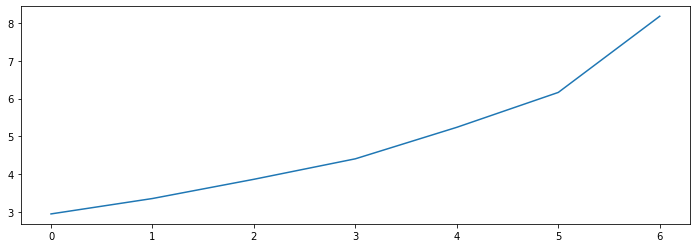

In [210]:
def F_OMP(X_total, tol = 0.0, F = [], normalize = True, is_sem = False, tol_res = 0.0, verbose = True):
    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    T, n = np.shape(X_total)
    
    X, Y = X_total[:-1], X_total[1:]

    if is_sem: F = [i * (n + 1) for i in range(n)]
    
    # compute kernel spaces
    Psi = X.T.dot(X)  					# p times p
    K = X.T.dot(Y)	  					# p  times p
    Theta = [y.T.dot(y) for y in Y.T] 	# 1 times 1
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas = [[] for _ in range(n)], [], np.zeros((n, n))
    
    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array	
    if normalize: norms = [np.linalg.norm(x) for x in X.T]
    
    edges, scores = [], [h.MSE(betas, X_total)]
    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)

        #print(gains.max())
        # stopping criterion
        if np.round(gains, 8).max() <= tol: break

        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n
        Lambda[col].append(row)
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)

            # update betas        	
            betas[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]
            
            edges.append([row, col])
            scores.append(h.MSE(betas, X_total))
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
        # check residual squared
        #print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))

        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, edges, scores

W_F_OMP, edge_order, scores = F_OMP(X, verbose = True)
print(f"OMP solution after iteratively adding the most correlated edge until we have a DAG:\n{np.round(W_F_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")

plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

### Compare all nine

A:
[[ 0.45  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.45  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.42  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.48  0.    0.    0.    0.    0.   -0.5 ]
 [ 0.    0.   -0.44 -0.42  0.    0.5   0.    0.    0.    0.  ]
 [ 0.43 -0.47  0.   -0.43 -0.44  0.   -0.49  0.    0.    0.  ]
 [ 0.    0.   -0.44 -0.41  0.    0.    0.   -0.49  0.    0.  ]
 [ 0.    0.   -0.41  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.5   0.   -0.44  0.46 -0.43  0.  ]]

P:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]].


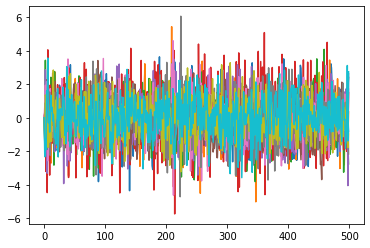

In [452]:
## Number of dimensions, number of edges, number of samples
T, n, s = 500, 10, 20

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.4, high = 0.5, tril = False)

idx = np.argmax(np.abs(A_true))

A_true[idx % n][idx // n] = A_true[idx // n][idx % n]
## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

### All Together

GREEDY LEAST SQUARES.
OLS solution after iteratively adding the most important edge until we have a dense DAG:
[[ 0.47 -0.04 -0.04 -0.01  0.    0.    0.   -0.07  0.    0.  ]
 [ 0.   -0.03  0.   -0.02  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.47 -0.01  0.01  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.4   0.    0.    0.    0.    0.    0.  ]
 [ 0.04  0.06  0.03 -0.52 -0.15  0.    0.    0.   -0.01 -0.54]
 [-0.08  0.06 -0.42 -0.42 -0.04  0.56 -0.03 -0.07  0.01  0.04]
 [ 0.4  -0.49 -0.05 -0.39 -0.4   0.   -0.51  0.02 -0.02  0.04]
 [ 0.   -0.03 -0.52 -0.39  0.    0.    0.   -0.46  0.04  0.  ]
 [ 0.   -0.03 -0.36  0.04  0.    0.    0.    0.    0.03  0.  ]
 [ 0.04 -0.09 -0.03  0.02  0.    0.    0.    0.47 -0.42 -0.  ]].
Importance of the added edges, from most to least important:
[[3, 3], [7, 7], [4, 9], [5, 5], [4, 3], [6, 6], [6, 1], [7, 2], [2, 1], [6, 4], [9, 7], [5, 3], [5, 2], [9, 8], [0, 0], [6, 0], [7, 3], [6, 3], [8, 2], [4, 4], [5, 0], [9, 1], [0, 7], [5, 7], [4,


OMP solution after iteratively removing the least correlated edge until we have a DAG:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.58  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.52]
 [ 0.    0.    0.    0.    0.    0.56  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.51  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.51  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]].
Importance of the removed edges, from least to most important:
[[3, 6], [3, 2], [0, 1], [2, 7], [0, 3], [4, 6], [0, 2], [4, 9], [1, 5], [5, 8], [4, 8], [4, 7], [2, 5], [2, 6], [2, 9], [5, 9], [8, 9], [6, 8], [3, 9], [3, 8], [2, 4], [3, 4], [0, 4], [7, 0], [1, 1], [1, 9], [1, 8], 

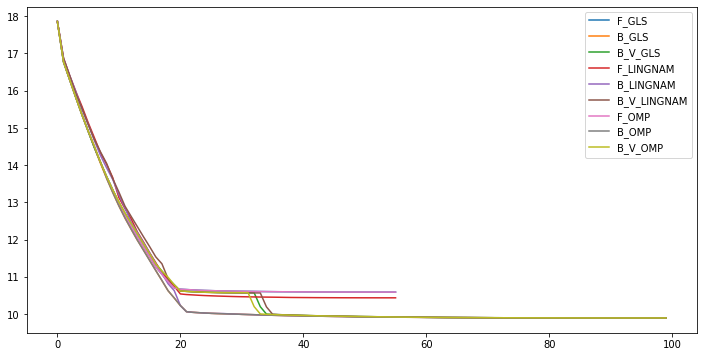

In [453]:
plt.figure(figsize = (12, 6))

print("GREEDY LEAST SQUARES.")
W_F_GLS, edge_order_F_GLS, scores_F_GLS = F_GLS(X)
print(f"OLS solution after iteratively adding the most important edge until we have a dense DAG:\n{np.round(W_F_GLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_GLS}.")
plt.plot(scores_F_GLS, label = "F_GLS")

W_B_GLS, edge_order_B_GLS, scores_B_GLS = B_GLS(X)
print(f"\nOLS solution after iteratively removing the least important edge until we have a DAG:\n{np.round(W_B_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_GLS}.")
plt.plot(np.flip(scores_B_GLS), label = "B_GLS")

W_B_V_GLS, edge_order_B_V_GLS, scores_B_V_GLS = B_V_GLS(X)
print(f"\nOLS solution after iteratively removing the least important violator until we have a DAG:\n{np.round(W_B_V_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_GLS}.")
plt.plot(np.flip(scores_B_V_GLS), label = "B_V_GLS")

print("LINGNAM LEAST SQUARES.")
W_F_LINGNAM_OLS, edge_order_F_LINGNAM_OLS, scores_F_LINGNAM_OLS = F_LINGNAM_OLS(X)
print(f"\nLINGNAM OLS solution after iteratively adding the largest edge until we have a dense DAG:\n{np.round(W_F_LINGNAM_OLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_LINGNAM_OLS}.")
plt.plot(scores_F_LINGNAM_OLS, label = "F_LINGNAM")

W_B_LINGNAM_OLS, edge_order_B_LINGNAM_OLS, scores_B_LINGNAM_OLS = B_LINGNAM_OLS(X)
print(f"\nLINGNAM solution after iteratively removing the smallest edge until we have a DAG:\n{np.round(W_B_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_LINGNAM_OLS}.")
plt.plot(np.flip(scores_B_LINGNAM_OLS), label = "B_LINGNAM")

W_B_V_LINGNAM_OLS, edge_order_B_V_LINGNAM_OLS, scores_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
print(f"\nLINGNAM solution after iteratively removing the smallest violator until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_LINGNAM_OLS}.")
plt.plot(np.flip(scores_B_V_LINGNAM_OLS), label = "B_V_LINGNAM")

print(f"ORTHOGONAL MATCHING PURSUIT.")
W_F_OMP, edge_order_F_OMP, scores_F_OMP = F_OMP(X, verbose = False, F = [])
print(f"\nOMP solution after iteratively adding the most correlated edge until we have a dense DAG:\n{np.round(W_F_OMP, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_OMP}.")
plt.plot(scores_F_OMP, label = "F_OMP")

W_B_OMP, edge_order_B_OMP, scores_B_OMP = B_OMP(X)
print(f"\nOMP solution after iteratively removing the least correlated edge until we have a DAG:\n{np.round(W_B_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
plt.plot(np.flip(scores_B_OMP), label = "B_OMP")

W_B_V_OMP, edge_order_B_V_OMP, scores_B_V_OMP = B_V_OMP(X)
print(f"\nOMP solution after iteratively removing the least correlated violator until we have a DAG:\n{np.round(W_B_V_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_OMP}.")
plt.plot(np.flip(scores_B_V_OMP), label = "B_V_OMP")

plt.legend()

### Backward Violations First

GREEDY LEAST SQUARES.

OLS solution after iteratively removing the least important violator until we have a DAG:
[[-0.54  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.02  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.59  0.47  0.06  0.    0.    0.    0.    0.    0.  ]
 [ 0.67  0.    0.   -0.05  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.52 -0.48  0.    0.    0.    0.    0.  ]
 [-0.67 -0.5   0.64 -0.08  0.    0.56  0.    0.    0.    0.  ]
 [ 0.    0.    0.54  0.57  0.   -0.52 -0.02  0.    0.    0.  ]
 [ 0.   -0.7   0.    0.    0.    0.    0.    0.03  0.    0.  ]
 [ 0.   -0.07  0.    0.    0.   -0.62 -0.51  0.    0.64  0.  ]
 [ 0.    0.    0.    0.6  -0.73  0.    0.    0.42  0.    0.06]].
Importance of the removed edges, from least to most important:
[[16, 9], [5, 17], [14, 5], [18, 6], [10, 3], [8, 12], [17, 3], [19, 0], [5, 0], [5, 7], [1, 16], [2, 11], [16, 6], [0, 14], [8, 9], [16, 19], [12, 3], [1, 10], [3, 13], [1, 18], [2, 8], [18, 

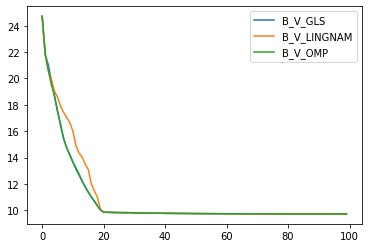

In [438]:
print("GREEDY LEAST SQUARES.")
print(f"\nOLS solution after iteratively removing the least important violator until we have a DAG:\n{np.round(W_B_V_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
plt.plot(np.flip(scores_B_V_GLS), label = "B_V_GLS")

print("LINGNAM LEAST SQUARES.")
print(f"\nOLS solution after iteratively removing the smallest violator until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
plt.plot(np.flip(scores_B_V_LINGNAM_OLS), label = "B_V_LINGNAM")

print(f"ORTHOGONAL MATCHING PURSUIT.")
print(f"\nOMP solution after iteratively removing the least correlated violator until we have a DAG:\n{np.round(W_B_V_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_OMP}.")
plt.plot(np.flip(scores_B_V_OMP), label = "B_V_OMP")

plt.legend()

### Backward Approaches

GREEDY LEAST SQUARES.

OLS solution after iteratively removing the least important edge until we have a DAG:
[[-0.54  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.6   0.47  0.05  0.    0.    0.    0.    0.    0.  ]
 [ 0.67  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.52 -0.48  0.    0.    0.    0.    0.  ]
 [-0.67 -0.49  0.64 -0.07  0.    0.56  0.    0.    0.    0.  ]
 [ 0.    0.    0.54  0.56  0.   -0.52  0.    0.    0.    0.  ]
 [ 0.   -0.7   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.62 -0.5   0.    0.64  0.  ]
 [ 0.    0.    0.    0.6  -0.73  0.    0.    0.42  0.    0.  ]].
Importance of the removed edges, from least to most important:
[[3, 6], [3, 2], [0, 1], [2, 7], [0, 3], [4, 6], [4, 9], [5, 8], [0, 2], [4, 8], [1, 5], [4, 7], [6, 8], [8, 9], [5, 9], [7, 0], [7, 9], [2, 9], [2, 5], [9, 0], [6, 0], [3, 8], [9, 6], [2, 6], [3,

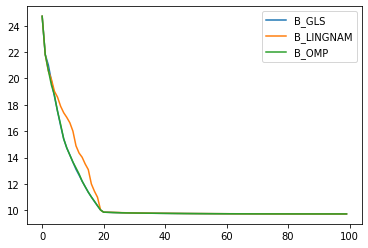

In [445]:
print("GREEDY LEAST SQUARES.")
print(f"\nOLS solution after iteratively removing the least important edge until we have a DAG:\n{np.round(W_B_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_GLS}.")
plt.plot(np.flip(scores_B_GLS), label = "B_GLS")

print("LINGNAM LEAST SQUARES.")
print(f"\nOLS solution after iteratively removing the smallest edge until we have a DAG:\n{np.round(W_B_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_LINGNAM_OLS}.")
plt.plot(np.flip(scores_B_LINGNAM_OLS), label = "B_LINGNAM")

print(f"ORTHOGONAL MATCHING PURSUIT.")
print(f"\nOMP solution after iteratively removing the least correlated edge until we have a DAG:\n{np.round(W_B_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_OMP}.")
plt.plot(np.flip(scores_B_OMP), label = "B_OMP")

plt.legend()

### Forward Approaches

GREEDY LEAST SQUARES.
OLS solution after iteratively adding the most important edge until we have a dense DAG:
[[-0.55  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.02  0.   -0.03  0.03  0.    0.    0.    0.    0.  ]
 [-0.03  0.59  0.47  0.07  0.01  0.    0.    0.    0.    0.  ]
 [ 0.68  0.    0.   -0.05  0.    0.    0.    0.    0.    0.  ]
 [-0.03  0.    0.   -0.52 -0.49  0.    0.    0.    0.    0.  ]
 [-0.65 -0.51  0.63 -0.09  0.05  0.56  0.    0.    0.    0.  ]
 [-0.02  0.06  0.53  0.56 -0.05 -0.53 -0.02  0.04  0.   -0.06]
 [-0.01 -0.7  -0.03 -0.03 -0.04 -0.05  0.    0.04  0.    0.  ]
 [-0.02 -0.06 -0.03 -0.02 -0.02 -0.62 -0.51  0.04  0.64 -0.01]
 [-0.02  0.02  0.03  0.6  -0.73 -0.05  0.    0.42  0.    0.06]].
Importance of the added edges, from most to least important:
[[5, 2], [3, 0], [2, 1], [5, 5], [2, 2], [8, 8], [5, 0], [0, 0], [4, 3], [7, 1], [5, 1], [9, 4], [4, 4], [8, 6], [6, 3], [6, 2], [8, 5], [9, 3], [6, 5], [9, 7], [8, 1], [5, 4], [2, 3], [5, 3], [3,

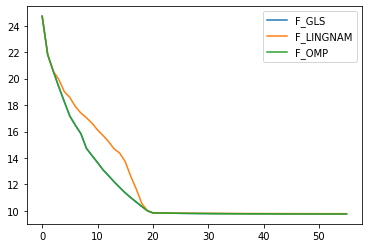

In [444]:
print("GREEDY LEAST SQUARES.")
print(f"OLS solution after iteratively adding the most important edge until we have a dense DAG:\n{np.round(W_F_GLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_GLS}.")
plt.plot(scores_F_GLS, label = "F_GLS")

print("LINGNAM LEAST SQUARES.")
print(f"\nOLS solution after iteratively adding the largest edge until we have a dense DAG:\n{np.round(W_F_LINGNAM_OLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_LINGNAM_OLS}.")
plt.plot(scores_F_LINGNAM_OLS, label = "F_LINGNAM")

print(f"ORTHOGONAL MATCHING PURSUIT.")
print(f"OMP solution after iteratively adding the most correlated edge until we have a DAG:\n{np.round(W_F_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_F_OMP}.")
plt.plot(scores_F_OMP, label = "F_OMP")

plt.legend()

### Greedy Least Squares

GREEDY LEAST SQUARES.
OLS solution after iteratively adding the most important edge until we have a dense DAG:
[[-0.55  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.02  0.   -0.03  0.03  0.    0.    0.    0.    0.  ]
 [-0.03  0.59  0.47  0.07  0.01  0.    0.    0.    0.    0.  ]
 [ 0.68  0.    0.   -0.05  0.    0.    0.    0.    0.    0.  ]
 [-0.03  0.    0.   -0.52 -0.49  0.    0.    0.    0.    0.  ]
 [-0.65 -0.51  0.63 -0.09  0.05  0.56  0.    0.    0.    0.  ]
 [-0.02  0.06  0.53  0.56 -0.05 -0.53 -0.02  0.04  0.   -0.06]
 [-0.01 -0.7  -0.03 -0.03 -0.04 -0.05  0.    0.04  0.    0.  ]
 [-0.02 -0.06 -0.03 -0.02 -0.02 -0.62 -0.51  0.04  0.64 -0.01]
 [-0.02  0.02  0.03  0.6  -0.73 -0.05  0.    0.42  0.    0.06]].
Importance of the added edges, from most to least important:
[[5, 2], [3, 0], [2, 1], [5, 5], [2, 2], [8, 8], [5, 0], [0, 0], [4, 3], [7, 1], [5, 1], [9, 4], [4, 4], [8, 6], [6, 3], [6, 2], [8, 5], [9, 3], [6, 5], [9, 7], [8, 1], [5, 4], [2, 3], [5, 3], [3,

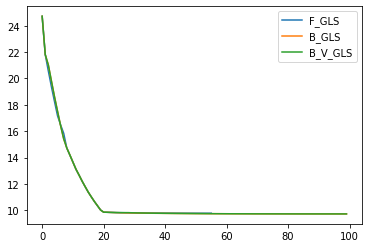

In [447]:
print("GREEDY LEAST SQUARES.")
print(f"OLS solution after iteratively adding the most important edge until we have a dense DAG:\n{np.round(W_F_GLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_GLS}.")
plt.plot(scores_F_GLS, label = "F_GLS")

print(f"\nOLS solution after iteratively removing the least important edge until we have a DAG:\n{np.round(W_B_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_GLS}.")
plt.plot(np.flip(scores_B_GLS), label = "B_GLS")

print(f"\nOLS solution after iteratively removing the least important violator until we have a DAG:\n{np.round(W_B_V_GLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_GLS}.")
plt.plot(np.flip(scores_B_V_GLS), label = "B_V_GLS")

plt.legend()

### Orthogonal Matching Pursuit

ORTHOGONAL MATCHING PURSUIT.

OMP solution after iteratively adding the most correlated edge until we have a dense DAG:
[[-0.55  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.02  0.   -0.03  0.03  0.    0.    0.    0.    0.  ]
 [-0.03  0.59  0.47  0.07  0.01  0.    0.    0.    0.    0.  ]
 [ 0.68  0.    0.   -0.05  0.    0.    0.    0.    0.    0.  ]
 [-0.03  0.    0.   -0.52 -0.49  0.    0.    0.    0.    0.  ]
 [-0.65 -0.51  0.63 -0.09  0.05  0.56  0.    0.    0.    0.  ]
 [-0.02  0.06  0.53  0.56 -0.05 -0.53 -0.02  0.04  0.   -0.06]
 [-0.01 -0.7  -0.03 -0.03 -0.04 -0.05  0.    0.04  0.    0.  ]
 [-0.02 -0.06 -0.03 -0.02 -0.02 -0.62 -0.51  0.04  0.64 -0.01]
 [-0.02  0.02  0.03  0.6  -0.73 -0.05  0.    0.42  0.    0.06]].
Importance of the added edges, from most to least important:
[[5, 2], [3, 0], [2, 1], [5, 5], [2, 2], [8, 8], [5, 0], [0, 0], [4, 3], [7, 1], [5, 1], [9, 4], [4, 4], [8, 6], [6, 3], [6, 2], [9, 3], [8, 5], [6, 5], [9, 7], [5, 4], [8, 1], [2, 3], [5

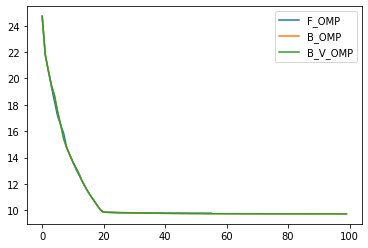

In [448]:
print(f"ORTHOGONAL MATCHING PURSUIT.")
print(f"\nOMP solution after iteratively adding the most correlated edge until we have a dense DAG:\n{np.round(W_F_OMP, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_OMP}.")
plt.plot(scores_F_OMP, label = "F_OMP")

print(f"\nOMP solution after iteratively removing the least correlated edge until we have a DAG:\n{np.round(W_B_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_OMP}.")
plt.plot(np.flip(scores_B_OMP), label = "B_OMP")

print(f"\nOMP solution after iteratively removing the least correlated violator until we have a DAG:\n{np.round(W_B_V_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_OMP}.")
plt.plot(np.flip(scores_B_V_OMP), label = "B_V_OMP")

plt.legend()

### LINGNAM-OLS

LINGNAM LEAST SQUARES.

OLS solution after iteratively adding the largest edge until we have a dense DAG:
[[-0.55  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.02  0.02  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.03  0.6   0.47  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.68 -0.04 -0.   -0.02  0.   -0.04  0.    0.    0.    0.  ]
 [-0.03  0.04  0.03 -0.52 -0.49  0.05  0.    0.    0.    0.  ]
 [-0.65 -0.52  0.63  0.    0.    0.56  0.    0.    0.    0.  ]
 [-0.02  0.06  0.53  0.55 -0.03 -0.52 -0.02  0.04  0.   -0.06]
 [-0.01 -0.68 -0.03 -0.04 -0.04 -0.02  0.    0.04  0.    0.  ]
 [-0.02 -0.06 -0.03 -0.   -0.04 -0.62 -0.51  0.04  0.64 -0.01]
 [-0.02  0.02  0.03  0.59 -0.73 -0.05  0.    0.42  0.    0.06]].
Importance of the added edges, from most to least important:
[[5, 2], [3, 0], [7, 1], [8, 5], [9, 4], [8, 8], [6, 2], [9, 3], [6, 3], [4, 3], [8, 6], [4, 4], [5, 5], [6, 5], [5, 0], [0, 0], [2, 2], [2, 1], [5, 1], [9, 7], [6, 1], [8, 1], [9, 9], [4, 5], [6, 9], 

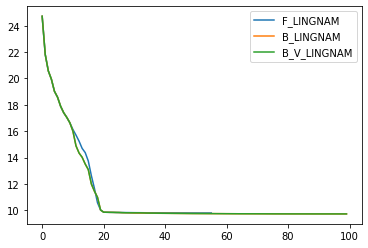

In [449]:
print("LINGNAM LEAST SQUARES.")
print(f"\nOLS solution after iteratively adding the largest edge until we have a dense DAG:\n{np.round(W_F_LINGNAM_OLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_F_LINGNAM_OLS}.")
plt.plot(scores_F_LINGNAM_OLS, label = "F_LINGNAM")

W_B_LINGNAM_OLS, edge_order, scores = B_LINGNAM_OLS(X)
print(f"\nOLS solution after iteratively removing the smallest edge until we have a DAG:\n{np.round(W_B_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_LINGNAM_OLS}.")
plt.plot(np.flip(scores_B_LINGNAM_OLS), label = "B_LINGNAM")

print(f"\nOLS solution after iteratively removing the smallest violator until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_B_V_LINGNAM_OLS}.")
plt.plot(np.flip(scores_B_V_LINGNAM_OLS), label = "B_V_LINGNAM")

plt.legend()

A:
[[-0.48  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.5   0.    0.  ]
 [ 0.43  0.45  0.    0.    0.    0.    0.  ]
 [ 0.43 -0.49  0.    0.    0.    0.    0.  ]
 [ 0.48  0.5   0.5   0.47  0.47  0.    0.  ]
 [-0.44 -0.42 -0.49  0.43 -0.49  0.42  0.  ]
 [-0.43  0.   -0.42  0.47 -0.42  0.    0.43]]

P:
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]].


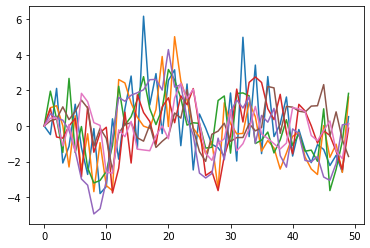

In [430]:
## Number of dimensions, number of edges, number of samples
T, n, s = 50, 7, 21

## Coefficient matrix
A_true = h.generate_A(n, s, low = 0.4, high = 0.5, tril = False)

idx = np.argmax(np.abs(A_true))

A_true[idx % n][idx // n] = A_true[idx // n][idx % n]

## True permutation
P_true = np.identity(n)

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

print(f"A:\n{np.round(A_true, 2)}\n\nP:\n{P_true}.")

GREEDY LEAST SQUARES.
OLS solution after iteratively adding the most important edge until we have a dense DAG:
[[-0.49  0.06  0.    0.    0.    0.    0.  ]
 [ 0.   -0.19  0.    0.    0.    0.    0.  ]
 [ 0.51  0.34 -0.13  0.    0.    0.    0.  ]
 [ 0.67 -0.41 -0.15  0.06  0.    0.    0.  ]
 [ 0.4   0.59  0.65  0.37  0.8   0.    0.  ]
 [-0.44 -0.48 -0.37  0.16 -0.31  0.42  0.23]
 [-0.56  0.42 -0.29  0.57 -0.27  0.    0.39]].
Importance of the added edges, from most to least important:
[[4, 4], [4, 1], [4, 0], [4, 2], [4, 3], [0, 0], [6, 3], [3, 0], [6, 0], [3, 1], [2, 0], [5, 2], [6, 6], [5, 5], [6, 4], [5, 0], [2, 1], [5, 1], [6, 2], [6, 1], [5, 4], [1, 1], [5, 6], [3, 2], [5, 3], [2, 2], [0, 1], [3, 3]].
ORTHOGONAL MATCHING PURSUIT: False
OMP solution after iteratively adding the most correlated edge until we have a DAG:
[[-0.49  0.06  0.    0.    0.    0.    0.  ]
 [ 0.   -0.19  0.    0.    0.    0.    0.  ]
 [ 0.51  0.34 -0.13  0.    0.    0.    0.  ]
 [ 0.67 -0.41 -0.15  0.06  0.  

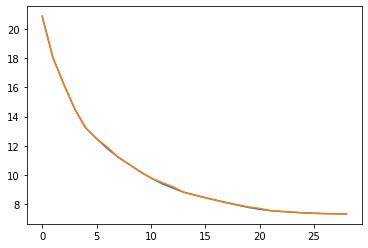

In [431]:
print("GREEDY LEAST SQUARES.")
W_F_GLS, edge_order_GLS, scores = F_GLS(X)
print(f"OLS solution after iteratively adding the most important edge until we have a dense DAG:\n{np.round(W_F_GLS, 2)}.")
print(f"Importance of the added edges, from most to least important:\n{edge_order_GLS}.")
plt.plot(scores, label = "F_GLS")

W_F_OMP, edge_order_OMP, scores = F_OMP(X, verbose = False, F = [])
print(f"ORTHOGONAL MATCHING PURSUIT: {edge_order_GLS == edge_order_OMP}")
print(f"OMP solution after iteratively adding the most correlated edge until we have a DAG:\n{np.round(W_F_OMP, 2)}.")
print(f"Importance of the removed edges, from least to most important:\n{edge_order_OMP}.")
plt.plot(scores, label = "F_OMP")